# Recommendations with IBM

In this notebook, I will be putting my recommendation skills to use on real data from the IBM Watson Studio platform.


Table of Contents<br>
    I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
    II. [Rank Based Recommendations](#Rank)<br>
    III. [User-User Based Collaborative Filtering](#User-User)<br>
    IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
    V. [Matrix Factorization](#Matrix-Fact)<br>
    VI. [Extras & Concluding](#conclusions)



In [1]:
import nltk

In [2]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline


In [4]:

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')


In [5]:
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [6]:
df_content.head()

,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [7]:
del df['Unnamed: 0']
del df_content['Unnamed: 0']


In [8]:

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [10]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [11]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [12]:
wdf = df.groupby(['email'])['article_id'].count()

In [13]:
wdf = pd.DataFrame(wdf).reset_index()

In [14]:
wdf

,email,article_id
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2
...,...,...
5143,ffc6cfa435937ca0df967b44e9178439d04e3537,2
5144,ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d,4
5145,ffe3d0543c9046d35c2ee3724ea9d774dff98a32,32
5146,fff9fc3ec67bd18ed57a34ed1e67410942c4cd81,10


In [15]:
wdf.columns = ['user', 'n_articles']

In [16]:
wdf

,user,n_articles
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2
...,...,...
5143,ffc6cfa435937ca0df967b44e9178439d04e3537,2
5144,ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d,4
5145,ffe3d0543c9046d35c2ee3724ea9d774dff98a32,32
5146,fff9fc3ec67bd18ed57a34ed1e67410942c4cd81,10


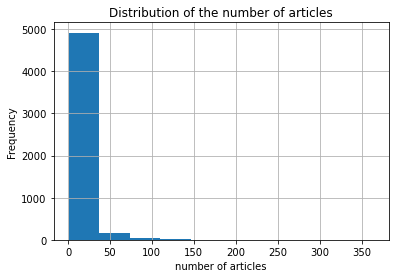

In [17]:
wdf.hist()
plt.xlabel('number of articles')
plt.title('Distribution of the number of articles')
plt.ylabel('Frequency')
plt.show()

In [18]:
article_count = df.groupby(['email'])['article_id'].count()

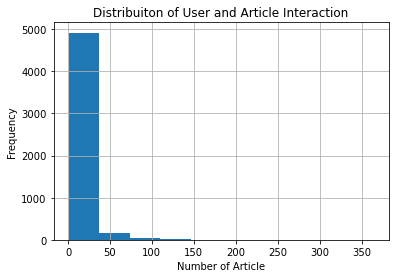

In [19]:
article_count.hist()
plt.xlabel("Number of Article")
plt.ylabel("Frequency")
plt.title("Distribuiton of User and Article Interaction");

In [20]:
wdf.describe()

,n_articles
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [21]:
# descriptive statistics
article_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [22]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [23]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [24]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [25]:
# finding duplicated values

for col in df_content.columns:
    print(f'Number of duplicates in {col}: {df_content[col].duplicated().sum()}')


Number of duplicates in doc_body: 19
Number of duplicates in doc_description: 33
Number of duplicates in doc_full_name: 5
Number of duplicates in doc_status: 1055
Number of duplicates in article_id: 5


In [26]:
df_content.doc_full_name.value_counts()

How smart catalogs can turn the big data flood into an ocean of opportunity                     2
Self-service data preparation with IBM Data Refinery                                            2
Graph-based machine learning                                                                    2
Using Apache Spark as a parallel processing framework for accessing REST based data services    2
Use the Primary Index                                                                           2
                                                                                               ..
Lorna Jane Mitchell & Surviving Failure with RabbitMQ                                           1
Meteor 1.4, MongoDB and Compose - Ready to Oplog                                                1
Optimizing a marketing campaign: Moving from predictions to actions                             1
Intro to Cloudant Query, declarative query API for JSON                                         1
Jupyter Notebooks wi

In [27]:
BM = df_content.article_id.duplicated()

In [28]:
df_content[BM]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [29]:
df_content[df_content['article_id'] == 221]

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221


Articles might have different doc_description , doc_body, and doc_status. However they are identifies with unique article_id or doc_full_name. 
So the duplicates should be removed based on article_id or doc_full_name.

In [30]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', keep='first', inplace=True)

In [31]:
print(df_content.article_id.duplicated().sum())
print(df_content.doc_full_name.duplicated().sum())

0
0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [32]:
df

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d


In [33]:
# The number of unique articles that have at least one interaction with a user.
BM = df.email.isna()
df[~BM].article_id.nunique()

714

In [34]:
# The number of unique articles in the dataset (whether they have any interactions or not).
df_content.article_id.nunique()

1051

In [35]:
# The number of unique users in the dataset. (excluding null values)
print(df.email.nunique())

5148


In [36]:
# The number of user-article interactions in the dataset
len(df)

45993

In [37]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [38]:
# most viewed article
df.article_id.value_counts().head(1)

1429.0    937
Name: article_id, dtype: int64

In [39]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [40]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [41]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [42]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # article_ids
    BM = get_top_article_ids(n, df=df)
    top_articles = list(df[df['article_id'].isin(BM)].title.unique())
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_id = list(df.article_id.value_counts().head(n).index)
    return top_articles_id # Return the top article ids

In [43]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [44]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # drop duplicates
    new_df = df.drop_duplicates()
    user_item = pd.crosstab(new_df.user_id, new_df.article_id)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [45]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [46]:
user_item


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similar_df = user_item @ user_item[user_item.index == user_id].T
    # sort by similarity
    sorted_df = similar_df.sort_values(user_id, ascending= False)
     # remove the own user's id
    sorted_df.drop(user_id, inplace=True)
    # create list of just the ids
    most_similar_users = sorted_df.index.to_list()
    return most_similar_users

In [48]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [49]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)].title.unique()
    article_names = np.sort(article_names)
    return article_names

def get_user_articles(user_id, user_item=user_item):
    
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_matrix = user_item[user_item.index == user_id] # user_id
    # article IDs
    article_ids = user_matrix.loc[:, user_matrix.eq(1).all()].columns.to_list()
    article_names = get_article_names(article_ids, df=df)
    return article_ids, article_names # return the ids and names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    recs = [] # contains m recommendations
    _, read_articles = get_user_articles(user_id)
    while len(recs) < m:
        for user in find_similar_users(user_id):
            # get the article that similar users have read
            article_ids, article_names = get_user_articles(user)
            for article in article_names:
                if (article not in recs) and (article not in read_articles):
                    recs.append(article)                
            
    return recs

In [50]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320.0, 232.0, 844.0])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [51]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # your code here
    neighbors_df = pd.DataFrame(columns=['neighbor_id','similarity', 'num_interactions'])
    neighbors_df['neighbor_id'] = find_similar_users(user_id)

    neighbors_df['similarity'] = (user_item @ user_item[user_item.index == 1].T).drop(1).sort_values(1, ascending=False).reset_index()[1]
    #(user_item @ user_item[user_item.index == user_id].T).drop(user_id).sort_values(user_id, ascending=False)[user_id]
    neighbors_df['num_interactions'] = user_item.loc[neighbors_df['neighbor_id']].sum(axis=1).reset_index()[0]

    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False,False],inplace=True)
    return neighbors_df

In [52]:
get_top_sorted_users(1)

,neighbor_id,similarity,num_interactions
0,3933,35,35
1,23,17,135
2,3782,17,135
3,203,15,96
4,4459,15,96
...,...,...,...
5141,2323,0,1
5143,2326,0,1
5144,2327,0,1
5146,2329,0,1


In [53]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # get top sorted users
    
    recs = [] # contains m recommendations
    neighbor_users = get_top_sorted_users(user_id)['neighbor_id']
    # get articles that the user has read
    read_ids, read_articles = get_user_articles(user_id)
    
    for user in neighbor_users:
        # get the article that similar users have read
        article_ids, article_names = get_user_articles(user)
        for article_id in article_ids:
            if len(recs) < m:
                if (article_id not in recs) and (article_id not in read_ids):
                    recs.append(article_id)    
            else:
                break
    rec_names = get_article_names(recs, df=df)
    return recs, rec_names 

In [54]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[34.0, 124.0, 158.0, 164.0, 256.0, 314.0, 316.0, 337.0, 382.0, 444.0]

The top 10 recommendations for user 20 are the following article names:
['d3heatmap: interactive heat maps' 'declarative machine learning'
 'generalization in deep learning'
 'learn tensorflow and deep learning together and now!'
 'leverage python, scikit, and text classification for behavioral profiling'
 'python machine learning: scikit-learn tutorial'
 'some random weekend reading' 'top 10 machine learning use cases: part 1'
 'what is text analytics?' 'xml2 1.0.0']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [55]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10]['neighbor_id']# Find the 10th most similar user to user 131

In [56]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**If we were given a new user, we won't have any data to make recommendation based on similarities with other user's readings. Therefore, we can only recommend articles based on popularity. To do this, we should adopt the rank-based method. Hence, the best function to provide such recommendation is `get_top_article_ids`**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [57]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)



In [58]:
assert set(new_user_recs) == set([1314.0,1429.0,1293.0,1427.0,1162.0,1364.0,1304.0,1170.0,1431.0,1330.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [59]:
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


In [60]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1037 non-null   object
 1   doc_description  1048 non-null   object
 2   doc_full_name    1051 non-null   object
 3   doc_status       1051 non-null   object
 4   article_id       1051 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 49.3+ KB


In [61]:
df_txt = df_content.copy()

In [62]:
df_txt.isna().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [63]:
# fillinf missing valus with emotiness
df_txt.doc_body.fillna('',inplace=True)
df_txt.doc_description.fillna('',inplace=True)
df_txt.doc_full_name.fillna('',inplace=True)

In [64]:
df_txt.isna().sum()

doc_body           0
doc_description    0
doc_full_name      0
doc_status         0
article_id         0
dtype: int64

In [65]:
# gathering values in 'doc_body','doc_description','doc_full_name' 
df_txt['text'] = df_txt['doc_body'] + df_txt['doc_description'] + df_txt['doc_full_name']

In [66]:
df_txt

,doc_body,doc_description,doc_full_name,doc_status,article_id,text
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,Skip navigation Sign in SearchLoading...\r\n\r...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA..."
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,Skip navigation Sign in SearchLoading...\r\n\r...
...,...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046,PouchDB-find is a new API and syntax that allo...
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047,We compare discriminative and generative learn...
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048,"Essays about data, building products and boots..."
1054,,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049,Learn how to use IBM dashDB as data store for ...


In [67]:
stop_words = set(stopwords.words('english'))
punctuations = str.maketrans('', '', string.punctuation)
stemmer = PorterStemmer()

def text_process(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    stripped = [w.translate(punctuations) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    stemmed = [stemmer.stem(word) for word in words]
    clean_text = " ".join(stemmed)
    return clean_text

In [68]:
df_txt['text'] = df_txt['text'].map(lambda x: text_process(x))

In [69]:
df_txt['text'].head()

0    skip navig sign searchload close yeah keep und...
1    free hunch navig kagglecom kagglecom commun da...
2    login sign learn path cours cours partner cour...
3    datalay high throughput low latenc scale boost...
4    skip navig sign searchload close yeah keep und...
Name: text, dtype: object

In [70]:
df_txt.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,text
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,skip navig sign searchload close yeah keep und...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,free hunch navig kagglecom kagglecom commun da...
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,login sign learn path cours cours partner cour...
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,datalay high throughput low latenc scale boost...
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,skip navig sign searchload close yeah keep und...


In [71]:
df_txt.article_id.duplicated().sum()

0

In [72]:
# make tfidf
tfidf_vectorizer = TfidfVectorizer()
article_tfidf = tfidf_vectorizer.fit_transform(df_txt['text'])
article_tfidf


<1051x36468 sparse matrix of type '<class 'numpy.float64'>'
	with 323801 stored elements in Compressed Sparse Row format>

In [73]:
# calculate cosine similarities
similarities = cosine_similarity(article_tfidf,article_tfidf)

In [74]:
df_sim = pd.DataFrame(similarities)

In [75]:
df_sim['article_id'] = df_txt['article_id']

In [76]:
df_sim

,0,1,2,3,4,5,6,7,8,9,...,1042,1043,1044,1045,1046,1047,1048,1049,1050,article_id
0,1.000000,0.066363,0.136538,0.026134,0.657414,0.056140,0.018117,0.065964,0.066711,0.093281,...,0.114300,0.294184,0.025189,0.026501,0.009700,0.007893,0.058524,0.095721,0.138529,0.0
1,0.066363,1.000000,0.167609,0.064178,0.080710,0.077623,0.063936,0.136154,0.113303,0.175295,...,0.077543,0.073967,0.048592,0.074596,0.033717,0.039094,0.102324,0.041662,0.182704,1.0
2,0.136538,0.167609,1.000000,0.072844,0.187099,0.057961,0.047278,0.161185,0.131334,0.262047,...,0.112741,0.114315,0.028962,0.026601,0.031856,0.021884,0.186926,0.100961,0.273823,2.0
3,0.026134,0.064178,0.072844,1.000000,0.026832,0.062419,0.104944,0.080385,0.027241,0.071906,...,0.034567,0.036472,0.007127,0.051355,0.021085,0.032338,0.025941,0.026530,0.062760,3.0
4,0.657414,0.080710,0.187099,0.026832,1.000000,0.057220,0.024172,0.091656,0.084833,0.122453,...,0.118844,0.138321,0.019349,0.019576,0.016233,0.003367,0.048844,0.159225,0.225312,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,0.009700,0.033717,0.031856,0.021085,0.016233,0.054991,0.015879,0.047728,0.009164,0.026886,...,0.013595,0.006397,0.007997,0.007957,1.000000,0.001967,0.013944,0.012626,0.019554,1041.0
1047,0.007893,0.039094,0.021884,0.032338,0.003367,0.014675,0.013043,0.012074,0.015800,0.023971,...,0.003239,0.007555,0.002627,0.006031,0.001967,1.000000,0.102275,0.006586,0.015708,1042.0
1048,0.058524,0.102324,0.186926,0.025941,0.048844,0.061419,0.029087,0.076321,0.061722,0.111920,...,0.043323,0.058795,0.030829,0.033426,0.013944,0.102275,1.000000,0.054584,0.111694,1043.0
1049,0.095721,0.041662,0.100961,0.026530,0.159225,0.031509,0.016332,0.109908,0.026524,0.166780,...,0.147965,0.059965,0.013696,0.019381,0.012626,0.006586,0.054584,1.000000,0.086921,1044.0


In [77]:
def make_content_recs(user_id, m = 10):
    '''
    INPUT:
    
    OUTPUT:
    
    '''
    # get user article list
    user_article_id,user_article_titles = get_user_articles(user_id)

    # get user article similarities
    user_similar = df_sim[df_sim.article_id.isin(user_article_id)]

    user_similar.drop('article_id',inplace=True,axis=1)

    user_similar = user_similar.T

    user_similar['avg_similarity'] = user_similar.mean(axis=1)

    user_similar.sort_values('avg_similarity',ascending=False,inplace=True)

    article_ids = user_similar.index.values

    final_article_id = article_ids[0:m]
    return final_article_id

In [78]:
make_content_recs(1, m = 10)

C:\Users\benfa\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([973, 586, 310, 800, 669, 1035, 124, 495, 76, 455], dtype=object)

In [79]:
get_article_names(make_content_recs(1, m = 10))

array(['70 amazing free data sources you should know',
       'building a business that combines human experts and data science',
       'machine learning for the enterprise',
       'machine learning for the enterprise.',
       'make machine learning a reality for your enterprise',
       'python machine learning: scikit-learn tutorial',
       'recent trends in recommender systems',
       'this week in data science (may 2, 2017)',
       'time series prediction using recurrent neural networks (lstms)',
       'top 10 machine learning algorithms for beginners'], dtype=object)

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [81]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [82]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [84]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

**This is different than the lesson because this time there's no missing values in the matrix. Furthermore, since the values in the matrix only consists of 1's and 0's, it's better to use the standard SVD rather than FunkSVD.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

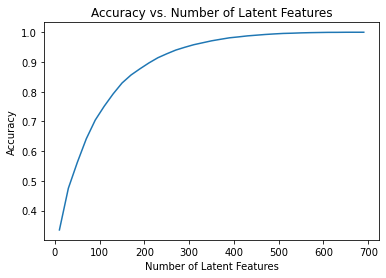

In [85]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [86]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    df_train = df_train.drop_duplicates(['article_id','user_id']) 
    df_test = df_test.drop_duplicates(['article_id','user_id'])
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test['user_id'].drop_duplicates().tolist()
    test_arts = df_test['article_id'].drop_duplicates().tolist()
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [87]:
user_item_train, user_item_test, test_idx, test_arts

(article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
 user_id                                                                      
 1                0       0       0       0       0       0       0       0   
 2                0       0       0       0       0       0       0       0   
 3                0       0       0       0       0       1       0       0   
 4                0       0       0       0       0       0       0       0   
 5                0       0       0       0       0       0       0       0   
 ...            ...     ...     ...     ...     ...     ...     ...     ...   
 4483             0       0       0       0       0       0       0       0   
 4484             0       1       0       1       0       0       0       0   
 4485             0       0       0       0       0       0       0       0   
 4486             0       0       0       0       0       0       0       0   
 4487             0       0       0       1       0 

In [88]:
# How many articles can we make predictions for in the test set?

len(test_arts)


574

In [89]:
# How many articles in the test set are we not able to make predictions for because of the cold 
#  start problem?
sum(user_item_test.index.isin(user_item_train.index)==False)


662

In [90]:
# How many users can we make predictions for in the test set?
user_item_test.index.isin(user_item_train.index).sum()

20

In [91]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
sum(user_item_test.columns.isin(user_item_train.columns)==False)


0

In [93]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [94]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [95]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [96]:
row_ids = user_item_train.index.isin(test_idx)
columns_ids = user_item_train.columns.isin(test_arts)
u_test = u_train[row_ids,:]
vt_test = vt_train[:,columns_ids]


C:\Users\benfa\AppData\Local\Temp\ipykernel_17896\1317279898.py:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  commmon_test_df = user_item_test.loc[(user_item_train.index & user_item_test.index)]


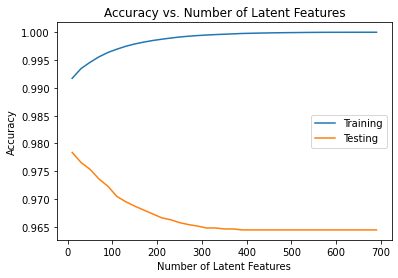

In [97]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:,:k],vt_test[:k,:]
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_est_test = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))

    # compute error for each prediction to actual value
    # training 
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    # test
    commmon_test_df = user_item_test.loc[(user_item_train.index & user_item_test.index)]
    diffs_test = np.subtract(commmon_test_df, user_item_est_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_est_train.shape[0]*user_item_est_train.shape[1]),label="Training");
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_est_test.shape[0]*user_item_est_test.shape[1]),label="Testing");
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.legend()
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**From the above graph, we can see as the number of latent features increase, the accuracy gets worse. However, we should also keep in mind that we were working with a very small sample size, so we won't be able to make any solid conclusions. Furthermore, the accuracy rate is very high despite tapering off as the number of latent features increase. This can be explained by the imbalance of the two classes where are have many more 0's than 1's. Therefore, we can conclude that accuracy is not the best metric to use here. Even if the model predicts all 0's, the accuracy will still be high! Perhaps, the better metric to track here is clicks which is a cookie-based method.**

**Due to the low sample size, I believe that A/B testing would be more approriate in this case. One group will have the new recommendation function and another will have the old one. We can then compute the mean interactions and use hypothesis testing to see if the new recommendation function is better than the old one. This first method that comes to mind is seperating the user groups by cookies(both groups should have the same number of users). This experiment should be run for 3-5 months or until we hit a good sample size. As mentioned earlier, this project only offered a small sample size which provides insufficient data to compare predictions.**

# END